In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import json
from bokeh.io import output_notebook, show, output_file, export_png
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, LogColorMapper, ColorBar, LogTicker
from bokeh.palettes import brewer
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE) 

Loading BokehJS ...

In [22]:
df_ind = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--females_aged_25_54_labour_force_participation_rate_percent--by--geo--time.csv')
df_ind.head(n=3)

geo  time  females_aged_25_54_labour_force_participation_rate_percent
0  afg  1990                                             14.566         
1  afg  1991                                             14.626         
2  afg  1992                                             14.689

In [3]:
df_sch = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--mean_years_in_school_women_25_to_34_years--by--geo--time.csv')
df_sch.head(n=3)

geo  time  mean_years_in_school_women_25_to_34_years
0  afg  1970                                       0.21
1  afg  1971                                       0.22
2  afg  1972                                       0.22

In [27]:
df_pop = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--population_total--by--geo--time.csv')
df_pop.head(n=3)

geo  time  population_total
0  afg  1800           3280000
1  afg  1801           3280000
2  afg  1802           3280000

# 2015

In [4]:
df_ind15 = df_ind[df_ind.time==2015]
df_ind15.head(n=3)

geo  time  female_industry_workers_percent_of_female_employment
24  afg  2015                                              5.659   
56  ago  2015                                              1.254   
88  alb  2015                                             13.884

In [5]:
df_sch15 = df_sch[df_sch.time == 2015]
df_sch15.head(n=3)

geo  time  mean_years_in_school_women_25_to_34_years
45   afg  2015                                       0.98
91   ago  2015                                       5.31
137  alb  2015                                      12.26

# visualize geo

In [6]:
gdf = gpd.read_file('dataset/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
gdf = gdf[['ADMIN', 'ADM0_A3', 'geometry']]
gdf = gdf.rename(columns={'ADMIN': 'country',
                          'ADM0_A3': 'geo'})
gdf['geo'] = gdf['geo'].str.lower()
gdf = gdf[gdf['country']!='Antarctica']
gdf.head(n=3)

country  geo  \
0                         Fiji  fji   
1  United Republic of Tanzania  tza   
2               Western Sahara  sah   

                                            geometry  
0  (POLYGON ((180 -16.06713266364245, 180 -16.555...  
1  POLYGON ((33.90371119710453 -0.950000000000000...  
2  POLYGON ((-8.665589565454809 27.65642588959236...

In [14]:
def plot_country(df_all, gdf, time, min_gdp, max_gdp, field, per='country'):
    df = gdf.merge(df_all[df_all['time']==time], how='left').fillna('No data')
    json_data = df.to_json()
    geosource = GeoJSONDataSource(geojson = json_data)
    palette = brewer['YlGnBu'][8][::-1]
    color_mapper = LinearColorMapper(
        palette=palette,
        low=min_gdp,
        high=max_gdp,
        nan_color='#d9d9d9')
    p = figure(plot_height=450,
               plot_width=800,
               title='{} per {} Year: {}'.format(field, per, time))
    p.patches('xs', 'ys', source=geosource,
              fill_color={'field': field,
                          'transform': color_mapper},
              legend=field)
    color_bar = ColorBar(
        color_mapper=color_mapper,
        location=(0,0),
        orientation='horizontal',
        ticker=LogTicker()
    )
    p.add_layout(color_bar, 'below')
    output_notebook(INLINE)
    return p

In [23]:
show(plot_country(df_ind, gdf, 2015,
    min(df_ind.females_aged_25_54_labour_force_participation_rate_percent),
    max(df_ind.females_aged_25_54_labour_force_participation_rate_percent),
    field='females_aged_25_54_labour_force_participation_rate_percent'))

Loading BokehJS ...

In [18]:
show(plot_country(df_sch, gdf, 2015,
    min(df_sch.mean_years_in_school_women_25_to_34_years),
    max(df_sch.mean_years_in_school_women_25_to_34_years),
    field='mean_years_in_school_women_25_to_34_years'))

Loading BokehJS ...

## relationship

In [28]:
df = df_ind.merge(df_sch).merge(df_pop)
df.head(n=3)

geo  time  females_aged_25_54_labour_force_participation_rate_percent  \
0  afg  1990                                             14.566            
1  afg  1991                                             14.626            
2  afg  1992                                             14.689            

   mean_years_in_school_women_25_to_34_years  population_total  
0                                       0.42          12249114  
1                                       0.43          12993657  
2                                       0.45          13981231

In [25]:
def weighted_corr(x, y, w):
    def weighted_mean(x, w):
        return np.sum(x*w) / np.sum(w)
    def weighted_cov(x, y, w):
        mean_x = weighted_mean(x, w)
        mean_y = weighted_mean(y, w)
        return np.sum(w * (x - mean_x) * (y - mean_y)) / np.sum(w)
    a = weighted_cov(x, y, w)
    b = weighted_cov(x, x, w)
    c = weighted_cov(y, y, w)
    return a / np.sqrt(b *c)

In [29]:
times = sorted(set(df.time))
def plot_for(col_a, col_a_name, col_b, col_b_name):
    cors = []
    for time in times:
        df_time = df[df.time == time]
        cor = weighted_corr(df_time[col_a], df_time[col_b], df_time.population_total)
        cors.append(cor)
    plt.plot(times, cors)
    plt.title('Correlation between {} and {}'.format(col_a_name, col_b_name))
    plt.ylim(-1, 1)
    plt.legend(regions)

NameError: name 'regions' is not defined

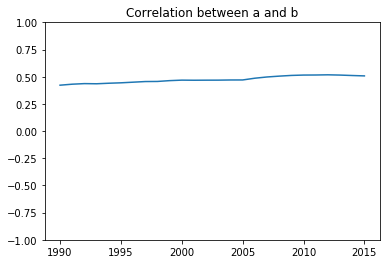

In [30]:
plot_for('females_aged_25_54_labour_force_participation_rate_percent', 'a',
         'mean_years_in_school_women_25_to_34_years', 'b')